In [18]:
import numpy as np
import networkx as nx
import os
import osmnx as ox
import time
import matplotlib.pyplot as plt

# Call this function to get the data
def get_data(city='Detroit', mode='bike'):
    G = ox.load_graphml('{}_{}.graphml'.format(city, mode), folder='../data/{}/'.format(city))
    convert_lengths_to_floats(G)
    print('Loaded {} Graph from {} Successfully!'.format(mode, city))
    return G
    

#### Define helper functions to compute metrics

In [2]:
def convert_lengths_to_floats(G):
    """
    Changes the attributes of the edges of graph G such that the 'length' field
    is a float rather than a string
    """
    for u, v, d in list(G.edges(data=True)):
        d['length'] = float(d['length'])

def get_edge_length(G, u, v):
    """
    given two nodes in graph G, return the straight line distance 
    (as the crow flies) between them
    """
    xdist = float(G.nodes[u]['x']) - float(G.nodes[v]['x'])
    ydist = float(G.nodes[u]['y']) - float(G.nodes[v]['y'])
    length = (xdist**2 + ydist**2)**0.5
    return length

def make_new_random_edge(G, u=None):
    """
    Return a tuple of nodes representing a random new and unique edge
    """
    if not u:
        u = np.random.choice(G.nodes(), 1)
        u = u[0]
    
    available = [node for node in G.nodes() if node not in G[u]]
    
    # choose v if not specified
    v = np.random.choice(available, 1)
    v = v[0]
    return (u, v)

    
def calc_directness(G, u, v):
    """
        Calculate the directness between two nodes u and v
        Directness is the ratio between:
            - the shortest node path length (number of edges times the length of each edge)
            - the straight line distance between those two nodes
        If v cannot be reached from u, then directness is zero
        
        G: An nx graph
        u: the starting node
        v: the ending node
        
    """
    try:
        path_length = nx.shortest_path_length(G, source=u, target=v, weight='length')
        direct_length = get_edge_length(G, u, v)
        ret = direct_length/path_length
    except:
        return 0
    return ret

def calc_avg_directness(G, pairs):
    """
    Calculates the average directness of n pairs of nodes. All of these nodes are already connected.
    G: An nx graph
    n: The number of pairs to use
    """
    d = 0
    n = len(pairs)
    for pair in pairs:
        d += calc_directness(G, pair[0], pair[1]) / n

    return d

def get_components(G):
    '''
    Get the connected components of G
    G: An nx graph
    
    Outputs
    wcc: A list of the components sorted by size
    '''
    wcc = [cc for cc in nx.weakly_connected_component_subgraphs(G)]
    wcc.sort(key=len, reverse=True)
    return wcc

def calc_lcc(G):
    '''
    Returns the number of nodes in the largest component of graph G
    G: An nx graph
    '''
    wcc = get_components(G)
    return len(wcc[0])

def euclidean_dist_vec(y1, x1, y2, x2):
    '''
    Calculate the euclidean distance between two points.
    '''
    distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    return distance
def make_connected_pairs(G, n):
    '''
    Creates n pairs of connected nodes from graph G
    G: an nx graph
    n: the number of pairs to return
    '''
    pairs = []
    for _ in range(n):
        start = np.random.choice(G.nodes(), 1)
        start = start[0]
        reachable = nx.descendants(G, start)
        if not reachable:
            continue
        end = np.random.choice(list(reachable), 1)
        end = end[0]
        pairs.append((start, end))
    return pairs

def make_random_pairs(G_bike, G_car, n = 250):
    '''
    Creates n pairs of random nodes from graph G
    G: an nx graph
    n: the number of pairs to return
    '''
    bike_pairs = []
    car_pairs = []
    for _ in range(n):
        bike_pair = np.random.choice(G_bike.nodes(), 2)
        b1 = G_bike.nodes[bike_pair[0]]
        b2 = G_bike.nodes[bike_pair[1]]
        bike_pairs.append(bike_pair)
                

        u = ox.get_nearest_node(G_car, (b1['x'], b1['y']))
        v = ox.get_nearest_node(G_car, (b2['x'], b2['y']))
        car_pairs.append((u,v))
    return bike_pairs, car_pairs
    

#### Define Methods for connecting the Graphs

In [26]:
def L2S(wcc):
    '''
    Find the closest pair of nodes between two different connected components.
    ---
    wcc: list connected components

    returns: dict nodes i and j and distance
    '''
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}

    for i in wcc[0].nodes(data=True):
        i_coord = (i[1]['y'], i[1]['x'])
        for j in wcc[1].nodes(data=True):
            j_coord = (j[1]['y'], j[1]['x'])
            dist = euclidean_dist_vec(i_coord[0], i_coord[1], j_coord[0], j_coord[1])
            if dist < closest_pair['dist']:
                closest_pair['i'] = i[0]
                closest_pair['j'] = j[0]
                closest_pair['dist'] = dist
    return closest_pair

def L2C(wcc):
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
    for i in wcc[0].nodes(data=True):
        i_coord = (i[1]['y'], i[1]['x'])
        for j in wcc[1:]:
            for k in j.nodes(data=True):
                j_coord = (k[1]['y'], k[1]['x'])
                dist = euclidean_dist_vec(float(i_coord[0]), float(i_coord[1]), float(j_coord[0]), float(j_coord[1]))
                if dist < closest_pair['dist']:
                    closest_pair['i'] = i[0]
                    closest_pair['j'] = k[0]
                    closest_pair['dist'] = dist
    return closest_pair

def R2C(wcc):
    '''
    Find the closest pair of nodes between two different connected components.
    ---
    wcc: list connected components

    returns: dict nodes i and j and distance
    '''
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
    num_clusters = len(wcc)
    cluster = np.random.choice(len(wcc))
    for i in wcc[cluster].nodes(data=True):
        i_coord = (i[1]['y'], i[1]['x'])
        for w,j in enumerate(wcc[1:]):
            for k in j.nodes(data=True):
                if w == cluster:
                    break
                j_coord = (k[1]['y'], k[1]['x'])
                dist = euclidean_dist_vec(float(i_coord[0]), float(i_coord[1]), float(j_coord[0]), float(j_coord[1]))
                if dist < closest_pair['dist']:
                    closest_pair['i'] = i[0]
                    closest_pair['j'] = k[0]
                    closest_pair['dist'] = dist
    return closest_pair

def Closest(wcc):
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
    for v,i in enumerate(wcc[0:]):
            for u in i.nodes(data=True):
                i_coord = (u[1]['y'], u[1]['x'])
                for w,j in enumerate(wcc[0:]):
                    for k in j.nodes(data=True):
                        if w == v:
                            break
                        j_coord = (k[1]['y'], k[1]['x'])
                        dist = euclidean_dist_vec(float(i_coord[0]), float(i_coord[1]), float(j_coord[0]), float(j_coord[1]))
                        if dist < closest_pair['dist']:
                            closest_pair['i'] = u[0]
                            closest_pair['j'] = k[0]
                            closest_pair['dist'] = dist
    return closest_pair


In [27]:
def new_city(G, algy, length, random_pairs, debug=False):
    """
    wcc = Sorted list of weakly connected subgraphs
    algy = desired path-adding algorithm
    
    """
    added_edges = []
    tot_length = [0]
    directness_random = []
    lccs = []
    i = 0
    while sum(tot_length) < length:
        wcc = get_components(G)
        if debug:
            print(np.round(100*sum(tot_length) / length, 2), '% Complete')
        lccs.append(len(wcc[0]))
        directness_random.append(calc_avg_directness(G, random_pairs))
        
        added_edge = algy(wcc)
        edge = (added_edge['i'],added_edge['j'],added_edge['dist'])
        G.add_edge(edge[0], edge[1], length = edge[2])
        added_edges.append(edge)
        tot_length.append(edge[2])
        
        i = i+1
        
    wcc = get_components(G)
    lccs.append(len(wcc[0]))
    directness_random.append(calc_avg_directness(G, random_pairs))
    return G, added_edges, tot_length, directness_random, lccs

In [21]:
name = 'Detroit'
G_bikes = get_data(name)
G_cars = get_data(name, mode='drive')

bike_pairs, car_pairs = make_random_pairs(G_bikes, G_cars, n=250)

G_L2S, _, lengths_L2S, directness_L2S, lccs_L2S = new_city(G_bikes, L2S, 35000, bike_pairs)


Loaded bike Graph from Detroit Successfully!
Loaded drive Graph from Detroit Successfully!


In [22]:
name = 'Detroit'
G_bikes = get_data(name)
G_L2C, _, lengths_L2C, directness_L2C, lccs_L2C = new_city(G_bikes, L2C, 35000, bike_pairs)

Loaded bike Graph from Detroit Successfully!


In [ ]:
name = 'Detroit'
G_bikes = get_data(name)
G_R2C, _, lengths_R2C, directness_R2C, lccs_R2C = new_city(G_bikes, R2C, 35000, bike_pairs)

Loaded bike Graph from Detroit Successfully!


In [ ]:
plt.plot(np.cumsum(lengths), lccs)

plt.title('LCC in Copenhagen, L2S Algorithm')
plt.xlabel('Length Added')
plt.ylabel('LCC')
plt.show()

In [ ]:
plt.figure()
directness
plt.plot(np.cumsum(lengths), directness)

plt.title('Average Directness, L2S Algorithm')
plt.xlabel('Length Added')
plt.ylabel('Directness')
plt.show()
directness

In [ ]:
rcc = calc_avg_directness(G_cars, car_pairs)
print(rcc)


deltaL2S = np.array(directness_L2S) - directness_L2S[0]
plt.plot(np.cumsum(lengths_L2S), deltaL2S)

deltaL2C = np.array(directness_L2C) - directness_L2C[0]
plt.plot(np.cumsum(lengths_L2C), deltaL2C)

deltaR2C = np.array(directness_R2C) - directness_R2C[0]
plt.plot(np.cumsum(lengths_R2C), deltaR2C)

plt.title('Average Directness for Detroit')
plt.xlabel('Length Added')
plt.ylabel('Normalized Directness')
plt.legend(['L2S Algorithm', 'L2C Algorithm', 'R2C Algorithm'])
plt.show()

In [33]:
len(deltaR2C)

1362

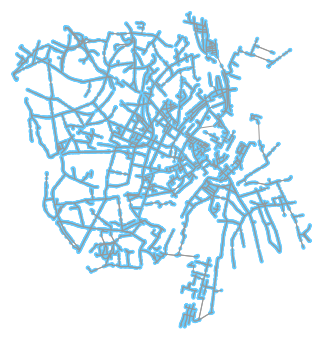

In [175]:


wcc = get_components(G_new)
G_super = nx.compose(wcc[0], wcc[1])
colors = ['r', 'b', 'g', 'y', 'm', 'k', 'c']

ox.plot_graph(G_super)
# plt.figure()


# for i in range(3):
#     f, ax = ox.plot_graph(wcc[i], edge_color=colors[i%7], node_color=colors[i%7], show=False, close=False)
    
plt.show()
# ox.plot_graph(G_new)

In [45]:

import matplotlib.pyplot as plt

# plt.plot(lengths, direcness1)
# plt.plot(lengths, directness2)
# plt.plot(lengths, lccs)
# plt.show()

print(lccs)
plt.figure
plt.semilogx(lengths[7:], lccs[1:])
plt.show()
lengths[6:]
lccs

We need to compute the probability that a person takes the car route versus the bike route. One one extreme, we expect to see people who bike every where no matter what. On the other extreme, we expect to see people who drive everywhere no matter what. In the middle, we expect to see pragmatic people who take the route that is simply faster than the other.

To do this, we need to compare the efficiency of taking each mode of transportation.

In [50]:
def route_decision(directness_bike, directness_car, threshold):
    '''
    directness_bike: The directness of taking a bike between two different nodes
    directness_car: The directness of taking a car between two different nodes
    threshold: decision threshold (from zero to one)
        if threshold == 1: the user will always choose to bike
        if threshold == 0.5: the user will always choose the more efficient route
        if threshold == 0: the user will always choose to drive
    
    returns 1 if the user bikes
    returns 0 if the user drives
    '''
#     if threshold == 0:
#         return 0
#     print(directness_bike)


#     if directness_bike < directness_car:
#         (directness_car - directness_bike) / directness_car
#     else:
        
#     if directness_bike > directness_car:
        
#         if directness_car / directness_bike > 0.6:
            
#         return directness_car / directness_bike
#     else:
#         return -directness_bike / directness_car
#     if threshold == 0:
#         return directness_bike > directness_car
#     elif threshold > 0:
#         if directness_bike > directness_car:
#             return 1
#         else:
#             return 1-(directness_bike / directness_car) < threshold
#     else:
#         if directness_car > directness_bike:
#             return 0
#         else:
#             return 1 - (directness_car / directness_bike) < abs(threshold)
    

    
    
    # bike bias
    dcar = directness_car**-1
    dbike = directness_bike**-1
    
    return (1-threshold)*dbike < (threshold)*dcar
        
#     if efficiency_ratio > 1:
#         efficiency_ratio = efficiency_ratio ** -1 * -1
    return efficiency_ratio

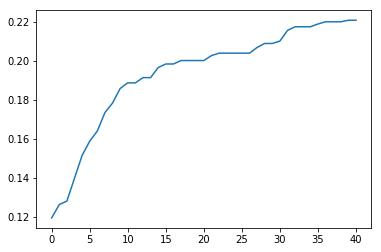

0.10739014520556886

In [51]:
%matplotlib inline
plt.plot(directness)
plt.show()
rcc

(101, 41)


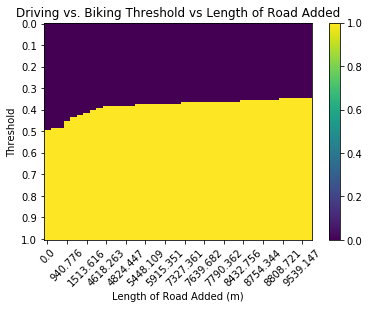

In [58]:
rcc = calc_avg_directness(G_cars, car_pairs) 
nthresh = 101
thresholds = np.linspace(0, 1, nthresh)
ds = np.empty((nthresh, len(directness)))
print(np.shape(ds))
for i in range(len(directness)):
    for j in range(nthresh):
        bcc = directness[i]
        ds[j][i] = route_decision(bcc, rcc, thresholds[j])

plt.imshow(ds, interpolation='nearest', aspect='auto')
plt.xticks(np.arange(0, len(lengths), step = 3), np.round(np.cumsum(lengths)[::3], decimals=3), rotation=45)
plt.yticks(np.arange(0, nthresh, step=10), np.round(thresholds[::10], decimals=1))
plt.colorbar()

plt.xlabel('Length of Road Added (m)')
plt.ylabel('Threshold')
plt.title('Driving vs. Biking Threshold vs Length of Road Added')
plt.show()

In [91]:
def route_decision_2(directness_bike, directness_car):
    '''
    directness_bike: The directness of taking a bike between two different nodes
    directness_car: The directness of taking a car between two different nodes
    
    returns threshold needed to ensure the user will choose to bike
    threshold: decision threshold (from zero to one)
        if threshold == 1: the user will always choose to bike
        if threshold == 0.5: the user will always choose the more efficient route
        if threshold == 0: the user will always choose to drive
    
    '''
    dcar = directness_car**-1
    dbike = directness_bike**-1
    
    return dbike / (dcar + dbike)


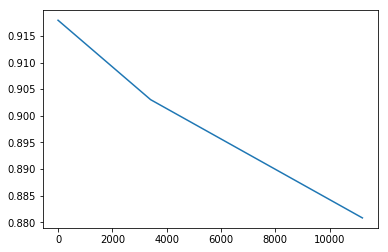

In [92]:
alphas = []
for d in directness:
    alphas.append(route_decision_2(d, rcc))
plt.plot(np.cumsum(lengths), alphas)